In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet
from tyssue import config

from tyssue.core.generation import create_anchors

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.core.objects import get_opposite

#from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.vispy_draw import vp_view
from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.stores import load_datasets



In [2]:
min_settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-8,    
            'gtol': 1e-8},
        }
    }


def load_before_apopto():

    h5store = 'before_apoptosis.hf5'
    #h5store = 'small_hexagonal.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    specs = config.geometry.spherical_sheet()
    sheet = Sheet('fold', datasets, specs)
    geom.update_all(sheet)

    # ## Remove dead cells at boundary
    boundary_cells = sheet.face_df[sheet.face_df.is_alive==0].index
    for cell in boundary_cells:
        remove_face(sheet, cell)

    sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)

    sheet.vert_df.is_active = 1
    create_anchors(sheet)
    
    nondim_specs = config.dynamics.quasistatic_sheet_spec_anchors()
    nondim_specs['edge']['anchor_tension'] = 0.3
    dim_model_specs = model.dimentionalize(nondim_specs)
    sheet.update_specs(dim_model_specs, reset=True)

    # sheet.vert_df.loc[dead_src, 'is_active'] = 0
    return sheet

sheet = load_before_apopto()
geom.update_all(sheet)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:728: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


In [62]:
hdf5.save_datasets('before_apoptosis_anchors.hf5', sheet)

In [3]:
canvas, view = vp_view(sheet, coords=['z', 'x', 'y'])

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)


In [4]:
sheet.vert_df.head()

,is_active,z,x,y,old_idx,basal_shift,rho,height,radial_tension,at_border,is_anchor
vert,,,,,,,,,,,
0,1,-62.888574,38.401664,-3.565528,932.0,28.985131,73.772445,44.787314,0.0,0,0
1,1,-61.458644,38.760006,0.120342,933.0,28.985131,72.660288,43.675157,0.0,0,0
2,1,-63.379461,38.436309,2.914589,934.0,28.985131,74.180865,45.195734,0.0,0,0
3,1,-57.318507,39.200702,-1.942695,935.0,28.985131,69.468557,40.483426,0.0,0,0
4,1,-55.176069,39.326057,3.286876,936.0,28.985131,67.836132,38.851002,0.0,0,0


In [6]:
res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:728: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


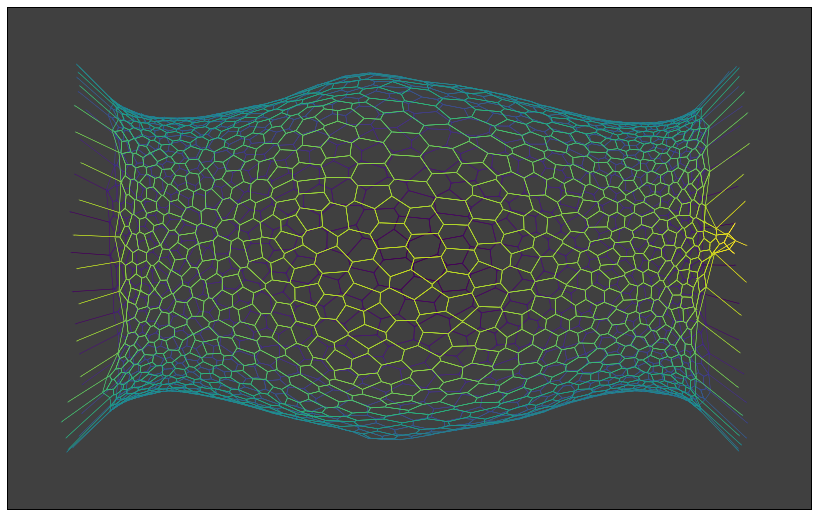

In [7]:
def leg_joint_view(sheet, coords=['z', 'y', 'x']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    ax.set_xlim(-80, 80)
    ax.set_ylim(-50, 50)
    ax.set_axis_bgcolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_frame_on(False)
    fig.set_size_inches((16, 9))
    fig.set_frameon(False)
    fig.set_clip_box(ax.bbox)
    return fig, ax

fig, ax = leg_joint_view(sheet)
plt.savefig('before.png', bbox_inches='tight')

In [8]:
res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


number of apoptotic cells: 10


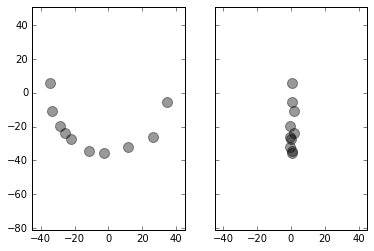

In [10]:
def apopto_pdf(zed, theta, z0=0.,
               width_apopto=1.5, amp=0.7):
    p = (np.exp(-(zed - z0)**2 / width_apopto**2) *
         (1 - amp*(np.cos(theta/2)**2)))
    return p

def get_apopto_cells(sheet):

    np.random.seed(42)
    sheet.face_df['theta'] = np.arctan2(sheet.face_df['x'],
                                        sheet.face_df['y'])
    p_apopto = apopto_pdf(sheet.face_df['z'], sheet.face_df['theta'])
    rand_field = np.random.random(sheet.face_df.shape[0])
    apopto_cells = p_apopto[p_apopto>rand_field].index
    apopto_cells = np.array([c for c in sheet.face_df.loc[apopto_cells].sort_values('x').index
                             if sheet.face_df.loc[c, 'is_alive']])
    return apopto_cells

apopto_cells = get_apopto_cells(sheet)
print('number of apoptotic cells: {}'.format(apopto_cells.size))

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
ax0.scatter(sheet.face_df.loc[apopto_cells, 'x'], 
            sheet.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax0.set_aspect('equal')


ax1.scatter(sheet.face_df.loc[apopto_cells, 'z'], 
            sheet.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax1.set_aspect('equal')
ax1.set_xlim(-45, 45);

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:728: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


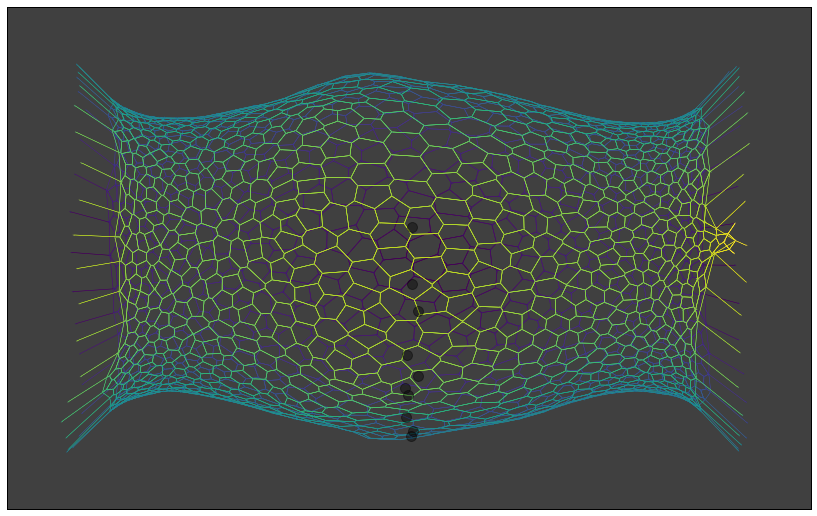

In [11]:
fig, ax = leg_joint_view(sheet)

ax.scatter(sheet.face_df.loc[apopto_cells, 'z'], 
           sheet.face_df.loc[apopto_cells, 'y'], c='k',
           s=100, alpha=0.4)

#plt.savefig('before.png', bbox_inches='tight')

In [26]:
from tyssue.behaviors.sheet_events import SheetEvents
from tyssue.behaviors.behaviors import apoptosis_time_table
from tyssue.topology.sheet_topology import remove_face
import os

import logging
logger = logging.Logger('event_log')

def get_time_table(sheet, apopto_cells,
                   events):

    time_tables = []
    for strat_t, cell in enumerate(apopto_cells):

        times, time_table = apoptosis_time_table(sheet, cell,
                                                 events, start_t=strat_t)
        time_tables.append(time_table)
    time_table = pd.concat(time_tables).sort_index()
    times = time_table.index.levels[0]
    return times, time_table

def time_step(face_events, events,
              sheet, geom, model, dirname):

    for face, evts in face_events.iterrows():
        for event_name, event_arg in evts.dropna().items():
            if ((not sheet.face_df.loc[face, 'is_alive']) or
                np.isnan(sheet.face_df.loc[face, 'is_alive'])):
                logger.info('skipped: face: {}, event: {}'.format(face, event_name))
                continue
            events[event_name](face, event_arg)
            logger.info('done: face: {}, event: {}'.format(face, event_name))
    
    res = solver.find_energy_min(sheet, geom, model, **settings)


    
def run_sim(sheet, apopto_cells,
            geom, model, dirname):
    
    times, time_table = get_time_table(sheet, apopto_cells,
                                       events)
    event_logfile = os.path.join(dirname, 'events.log')
    hdlr = logging.FileHandler(event_logfile)
    hdlr.setLevel('INFO')
    logger.addHandler(hdlr)
    
    for t in times:
        face_events = time_table.loc[t]
        time_step(face_events, events,
                  sheet, geom, model, dirname)
        fig, ax = leg_joint_view(sheet)
        figname = os.path.join(
            dirname, 'fold_formation_{:03d}.png'.format(t))
        plt.savefig(figname, bbox_inches='tight')
        plt.close(fig)
    
    logger.removeHandler(hdlr)


In [27]:
settings = {
    'shrink_steps': 30,
    'rad_tension': 2.0,
    'contractile_increase': 2.0,
    'contract_span': 3
    }

tensions = [0, 0, 2, 2]
contracts = [0, 2, 0, 2]
dirnames = ['{}_lambda_{}_gamma'.format(l, g)
            for l, g in zip(tensions, contracts)]

for l, g, dirname in zip(tensions, contracts, dirnames):
    
    datasets = {key: val.copy() for key, val
                in sheet.datasets.items()}
    specs = sheet.specs
    
    sheet2 = Sheet('fold', datasets, specs) # load_before_apopto()
    events = SheetEvents(sheet2, model, geom).events
    res = solver.find_energy_min(sheet2, geom, model,
                                 **min_settings)
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    settings.update(
        {'rad_tension': l,
         'contractile_increase': g})
    sheet2.settings['apoptosis'] = settings
    run_sim(sheet2, apopto_cells, 
            geom, model, dirname)

    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:728: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


starting 0_lambda_0_gamma
0_lambda_0_gamma done
~~~~~~~~~~~~~~~~~~~~~

starting 0_lambda_2_gamma
0_lambda_2_gamma done
~~~~~~~~~~~~~~~~~~~~~

starting 2_lambda_0_gamma
2_lambda_0_gamma done
~~~~~~~~~~~~~~~~~~~~~

starting 2_lambda_2_gamma
2_lambda_2_gamma done
~~~~~~~~~~~~~~~~~~~~~



/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:728: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


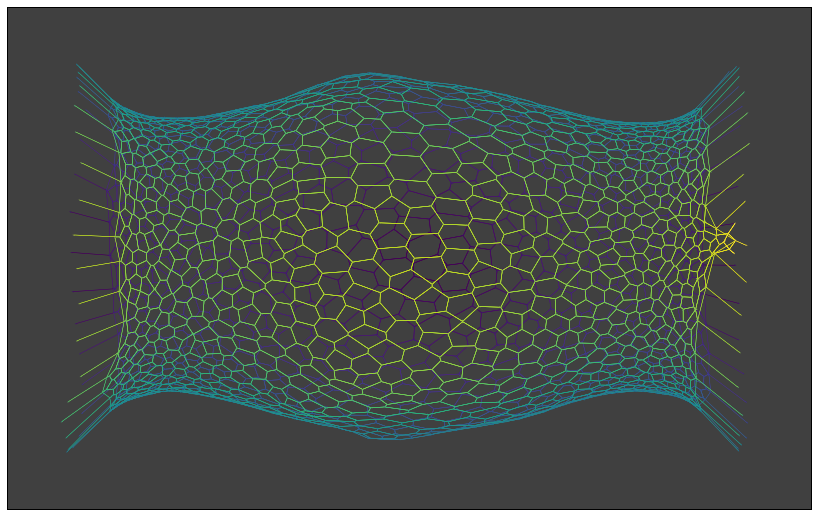

In [28]:
fig, ax = leg_joint_view(sheet)

In [7]:
vp_view(sheet)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
